In [1]:
import tensorflow as tf;
import pandas as pd;
import numpy as np;
import keras.backend as k;

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
data_dir="pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

OBTAIN THE DATA ABOUT THE NUMBER OF FILES WE HAVE IN THE DIRECTORY

In [4]:
import os;
filename=[data_dir+filename for filename in os.listdir(data_dir)]
print(filename)

['pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt', 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt', 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']


AND THEN WE CREATE A FUNCTION TO READ THE LINES OF THE FILES

In [5]:
def get_lines(filename):
    with open(filename,"r")as f:
        return f.readlines()

NOW WE CREATE A FUNCTION TO PREPROCESS THE DATA

In [6]:
def preprocess_text(filename):
    input_lines=get_lines(filename)#read input from the file
    abstract_lines=""#create an empty string
    abstract_samples=[]#create an empty list to concatenate later
    for line in input_lines:
        if line.startswith("###"):# if the line starts with ### we say it is an ID so abstract id is equal to id
            abstract_id=line
            abstract_lines=""#we reset the abstract line here
        elif line.isspace():#to check if there is a new line we use this method!
            abstract_line_split=abstract_lines.splitlines()#if there is a new line we split it right there
            for abstract_line_number,abstract_line in enumerate(abstract_line_split):#now in that split we find which is the target,text,etc
                line_data={}#we create an empty dict and make use of enumerate to keep track of the line number.
                target_text_split=abstract_line.split("\t")#we split the data when we have found a tabspace and after that the data that 
                line_data["target"]=target_text_split[0]#remains in the first index is the target and the words next to it are considered
                line_data["text"]=target_text_split[1]# as texts 
                line_data["line_number"]=abstract_line_number
                line_data["total_lines"]=len(abstract_line_split)
                abstract_samples.append(line_data)#here we append the dictionary to the original abstract sample list!
        else:#if the above conditions arent fulfilled then the sentence is labelled sentence so just concatenate the line
            abstract_lines +=line
    return abstract_samples                
            

NOW WE OBTAIN THE TRAIN DATA,TEST DATA,VALIDATION DATA

In [7]:
%%time 
train_samples=preprocess_text(data_dir+"train.txt")#Note that we use %%time to obtain the cpu time taken to execute and wall time 
test_samples=preprocess_text(data_dir+"test.txt")
val_samples=preprocess_text(data_dir+"dev.txt")
len(val_samples),len(train_samples),len(test_samples)

CPU times: total: 359 ms
Wall time: 362 ms


(30212, 180040, 30135)

In [8]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

NOW WE CREATE THE DATAFRAME FOR THE SAMPLES USING PANDAS

In [9]:
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,A total of @ patients with primary knee OA wer...,1,12
2,METHODS,Outcome measures included pain reduction and i...,2,12
3,METHODS,Pain was assessed using the visual analog pain...,3,12
4,METHODS,Secondary outcome measures included the Wester...,4,12
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,12
6,RESULTS,There was a clinically relevant reduction in t...,6,12
7,RESULTS,The mean difference between treatment arms ( @...,7,12
8,RESULTS,"Further , there was a clinically relevant redu...",8,12
9,RESULTS,These differences remained significant at @ we...,9,12


NOW THAT OUR DATA IS A DATAFRAME WE CAN DO SOME ANALYSIS ON IT!

In [10]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

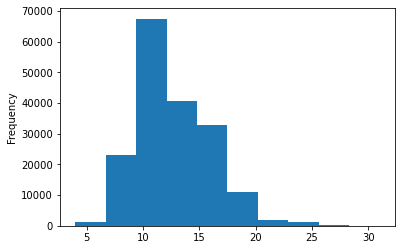

In [11]:
train_df.total_lines.plot(kind="hist")

now we get a list of sentences.. one of the most important inputs of the deeplearning model..
we get these easily by calling our dataframe into a list using the list() function on our "text" columns

In [12]:
train_sentences=train_df["text"].tolist()
test_sentences=test_df["text"].tolist()
val_sentences=val_df["text"].tolist()

In [13]:
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [14]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

NOW WE CONVERT THE TEXT INTO NUMERICAL VARIABLES, WE COULD JUST DO LABEL ENCODING AND BE FINE WITH IT BUT TENSORFLOW's CATEGORICAL CROSSENTROPY LOSS FUNCTION LIKES TO HAVE ONE HOT ENCODED LABELS SO WE KNOW NN LOVES NORMALIZED MODELS SO WE DO THIS

In [15]:
from sklearn.preprocessing import OneHotEncoder;
one_hot_encoder=OneHotEncoder(sparse=False)
train_df_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_df_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
val_df_one_hot=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))

HERE WE ENCODED THE TARGET SECTION OF THE DATAFRAME WHICH IS A CATEGORY.WE SET THE SPARSE VALUE TO FALSE TO NOT MAKE IT DENSE!

In [16]:
train_df_one_hot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

NOW WE LABEL ENCODE THE LABELS USING LABEL ENCODER FROM SKLEARN TO GET THE NUMBER OF CLASSES AND CLASS NAMES!!

In [17]:
from sklearn.preprocessing import LabelEncoder;
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_labels_encoded=label_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
val_labels_encoded=label_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))

c:\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
train_labels_encoded[:5]

array([3, 2, 2, 2, 2])

OBTAINED THE NO OF CLASSES AND THE NAMES OF THE CLASSES!!!!

In [19]:
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
print(num_classes,class_names)

5 ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


NOW WE ARE DONE PREPROCESSING THE MODEL TIME TO GET INTO SOME MODELLING EXPERIMENTS


 ********************************** MODEL_0 (BASELINE MODEL) *****************************************************

In [20]:
from sklearn.naive_bayes import MultinomialNB;
from sklearn.pipeline import Pipeline;
from sklearn.feature_extraction.text import TfidfVectorizer;
model_0=Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])
model_0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(X=val_sentences,y=val_labels_encoded)

0.7218323844829869

In [22]:
baseline_preds=model_0.predict(X=val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

 NOW WE PREPARE OUR DATA FOR DEEP SEQUENCE MODELS!
 WE HAVE TO DO TWO THINGS:
 1:Tokenization
 2:Embedding 
 THESE ARE VERY ESSENTIAL STEPS IN BUILDING AN NLP MODEL

In [23]:
from keras import layers;

NOW WE GOTTA TUNE OUR SENTENCES TO NUMBERS AND THUS IT IS A GOOD IDEA TO FIGURE OUT HOW MUCH WORDS ARE IN A SENTENCE.BECAUSE OUR MODEL WORKS BEST IF EACH SENTENCES ARE OF EQUAL LENGTH WHICH THEN IS CONVERTED TO BATCHES AND FIT IN THE MODEL!

FOR EXAMPLE IF A SENTENCE IS 15 WORDS LONG AND THE OTHER SENTENCE IS 20 WORDS LONG WE HAVE TO PAD THE 5 MISSING WORDS WITH 0's AND IT ENDS UP BEING THE SAME LENGTH AS THE LAST SENTENCE!

In [24]:
sentence_len=[len(sentence.split()) for sentence in train_sentences]# How long is each sentence on average?
avg_sen_len=np.mean(sentence_len)
avg_sen_len

26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

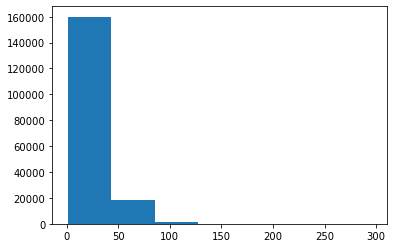

In [25]:
import matplotlib.pyplot as plt;
plt.hist(sentence_len,bins=7)

In [26]:
output_seq_len=np.percentile(sentence_len,95)
output_seq_len# this means that how long of a sentence covers 95% of the length
#it looks like 95% of the sentences in our train sentences have 55 words/tokens in thier dataframe

55.0

WHEN WE CREATE OUR TOKENIZATION LAYERS WE USE THIS VALUE TO TURN ALL OUR SENTENCE TO THE SAME LENGTH! MEANING ALL THE SENTENCES BELOW THIS NUMBER GETS PADDED WITH ZEROS!

 NOW WE CREATE THE TEXT VECTORIZER WE ONLY MODIFY max_tokens and the output_Sequence_length and keep rest of the parameters to default!

In [27]:

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization;
text_vectorizer=TextVectorization(max_tokens=68000,output_sequence_length=55)

In [28]:
text_vectorizer.adapt(train_sentences)

In [29]:
import random;
target_sentence=random.choice(train_sentences)
print(f"sentence:{target_sentence}")
print(f"Length of sentence:{len(target_sentence.split())}")
print(f"Vectorized sentence:{text_vectorizer([target_sentence])}")

sentence:Processing conditions have a large effect on the kinetics and bioavailability of isothiocyanates from broccoli .
Length of sentence:16
Vectorized sentence:[[ 2573   458    99     8   545    70    18     2  3940     3  2760     4
  30566    27 13465     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [30]:
# WE CAN GET THE STEREOTYPES OF VOCABULARIES OF THE VECTORIZED SENTENCES USING get_vocabulary method
text_vocab=text_vectorizer.get_vocabulary()
print(f"number of words in the vocabulary: {len(text_vocab)}")
print(f"the most commmon used words in the vocabulary: {text_vocab[:5]}")
print(f"the least used words in the vocabulary: {text_vocab[-5:]}")

number of words in the vocabulary: 64841
the most commmon used words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
the least used words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [31]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False}

NOW WE DO THE STEP OF EMBEDDING.. ALTHOUGH THE VECTORIZATION DOES THE CONVERSION OF WORDS TO NUMBERS IT DOESNT NECESSARILY MEAN WE ARE DONE.. FOR OUR NN MODEL TO UNDERSTAND THE DATA WE CONVERT THE NUMBERS TO VECTORS BY USING THE EMBEDDING LAYER

In [32]:
#creating a token embedding layer
token_embed=layers.Embedding(input_dim=len(text_vocab),output_dim=128,#different embedding sizes result in diff number of parameters to train
                             embeddings_initializer="uniform",mask_zero=True,#we use masking to handle variable sequence length to save space
                             name="token_embedding")

In [33]:
vectorized_sentence=text_vectorizer([target_sentence])
print(vectorized_sentence,vectorized_sentence.shape) # u can see the output words is of length 55

tf.Tensor(
[[ 2573   458    99     8   545    70    18     2  3940     3  2760     4
  30566    27 13465     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64) (1, 55)


In [34]:
embedded_sentence=token_embed(vectorized_sentence)
print(embedded_sentence,embedded_sentence.shape)# u can see the output shape is 128 with 55 words in its arsenal

tf.Tensor(
[[[-0.04777322  0.00605954 -0.02080641 ...  0.0152715  -0.03261013
    0.00192512]
  [-0.01762604  0.01562728  0.04527584 ... -0.01570773 -0.00540014
   -0.01733656]
  [ 0.03886446  0.01918742 -0.03928374 ... -0.00255007  0.0108964
    0.00860987]
  ...
  [-0.00224762  0.01723696  0.04666171 ...  0.0062607  -0.01528393
    0.0377068 ]
  [-0.00224762  0.01723696  0.04666171 ...  0.0062607  -0.01528393
    0.0377068 ]
  [-0.00224762  0.01723696  0.04666171 ...  0.0062607  -0.01528393
    0.0377068 ]]], shape=(1, 55, 128), dtype=float32) (1, 55, 128)


TO CREATE DATASETS AS FAST AS POSSIBLE there is this API called as the tf.data which enables faster data loading. we have gone through 
so many steps to preprocess the data but there are still a few steps that we can take to make it load faster!

In [35]:
#so now we turn our data into tensorflow datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_df_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_df_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_df_one_hot))

In [36]:
# now we take these datasets and turn them into the prefetch batches
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)#the tf,data.AUTOTUNE  will allow tensorflow to  determine the optimal 
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)#amount of compute  to use to prepare the datasets
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [37]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

 ******************************** MODEL 1:CONV1D WITH TOKEN EMBEDDINGS! *********************************
                    Input(text) -> Tokenize/Vectorize -> Embedding ->layers -> Output (labels/probability)

In [38]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [39]:
model_1.fit(train_dataset,epochs=5,steps_per_epoch=(0.1*len(train_dataset)),validation_data=val_dataset,validation_steps=(0.25*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 13s 8ms/step - loss: 0.9156 - accuracy: 0.6422 - val_loss: 0.6866 - val_accuracy: 0.7426
Epoch 2/5
562/562 [==============================] - 4s 8ms/step - loss: 0.6540 - accuracy: 0.7581 - val_loss: 0.6364 - val_accuracy: 0.7715
Epoch 3/5
562/562 [==============================] - 4s 8ms/step - loss: 0.6147 - accuracy: 0.7755 - val_loss: 0.5950 - val_accuracy: 0.7882
Epoch 4/5
562/562 [==============================] - 4s 8ms/step - loss: 0.5885 - accuracy: 0.7884 - val_loss: 0.5742 - val_accuracy: 0.7938
Epoch 5/5
562/562 [==============================] - 4s 8ms/step - loss: 0.5902 - accuracy: 0.7939 - val_loss: 0.5623 - val_accuracy: 0.8016


In [40]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 2s 2ms/step - loss: 0.5599 - accuracy: 0.8017


[0.5599410533905029, 0.8017013072967529]

In [41]:
model_1_preds=model_1.predict(val_dataset)

 *********************** MODEL 2: FEATURE EXTRACTION WITH PRETRAINED MODEL EMBEDDINGS *******************************
 

In [42]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")
#note that the USE embedding layer outputs a 512 dimensional vector unlike our previous model that outputs 128 dimensional vector

In [43]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [45]:
model_2.fit(train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset)))
    
    

Epoch 1/5
562/562 [==============================] - 9s 12ms/step - loss: 0.9152 - accuracy: 0.6506 - val_loss: 0.7955 - val_accuracy: 0.6878
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7689 - accuracy: 0.7021 - val_loss: 0.7567 - val_accuracy: 0.7045
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7538 - accuracy: 0.7109 - val_loss: 0.7410 - val_accuracy: 0.7098
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7200 - accuracy: 0.7229 - val_loss: 0.7133 - val_accuracy: 0.7271
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7269 - accuracy: 0.7208 - val_loss: 0.6924 - val_accuracy: 0.7340


 TRAINING THE MODEL WITH CHARACTER BASED TOKEN EMBEDDING!

In [46]:
def split_chars(text):
    return " ".join(text)
split_chars(random.choice(train_sentences))


'V a r i a b l e s   i n c l u d i n g   l e n g t h   o f   h o s p i t a l i s a t i o n   ,   t i m e   f o r   w o u n d   h e a l i n g   ,   t i m e   o f f   w o r k   ,   r e c u r r e n c e   a n d   s u r g i c a l   c o m p l i c a t i o n s   w e r e   e v a l u a t e d   .'

In [47]:
train_chars=[split_chars(text)for text in train_sentences]
test_chars=[split_chars(text)for text in test_sentences]
val_chars=[split_chars(text)for text in val_sentences]

In [48]:
train_sentences[:1]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .']

In [49]:
train_chars[0:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [50]:
char_lens=[len(i)for i in train_sentences]
np.mean(char_lens)

149.3662574983337

In [51]:
output_seq_char_len=int(np.percentile(char_lens,95))
print(output_seq_char_len)

290


(array([1.69034e+05, 1.07780e+04, 2.09000e+02, 1.60000e+01, 3.00000e+00]),
 array([1.000e+00, 2.780e+02, 5.550e+02, 8.320e+02, 1.109e+03, 1.386e+03]),
 <BarContainer object of 5 artists>)

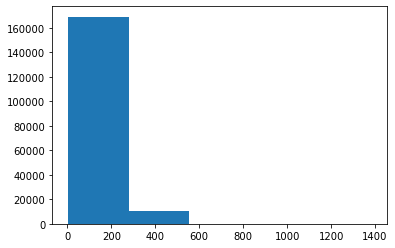

In [52]:
import matplotlib.pyplot as plt;
plt.hist(char_lens,bins=5)

IN EMBEDDING LAYER WE SET MAX TOKENS TO 28 i.e., THE 26 LETTERS OF THE ALPHABET AND ONE SPACE CHAR AND THE UNKNOWN TOKENS

In [53]:
import string;
print(string.ascii_lowercase+string.digits+string.punctuation)

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


CREATING A CHAR LEVEL TOKEN VECTORIZER INSTANCE

In [54]:
num_tokens=26+2 # no of aplhabets and a space and unexpected token
char_vectorizer=TextVectorization(max_tokens=num_tokens,
                                output_sequence_length=output_seq_char_len,#make sure this sequence length is int!
                                standardize="lower_and_strip_punctuation" #lower and strip method
                                )
char_vectorizer.adapt(train_chars)

In [55]:
char_vocab=char_vectorizer.get_vocabulary()
print(f"number of tokens in char vocabulary:{len(char_vocab)}")
print(f"Most common tokens:{char_vocab[:5]}")
print(f"Least common tokens:{char_vocab[-5:]}")


number of tokens in char vocabulary:28
Most common tokens:['', '[UNK]', 'e', 't', 'i']
Least common tokens:['k', 'x', 'z', 'q', 'j']


CREATING THE CHARACTER EMBEDDING LAYER..HERE INPUT DIM IS NUM OF TOKENS AND OUTPUT DIM IS SET TO 25.

In [56]:
char_embed=tf.keras.layers.Embedding(input_dim=num_tokens,
                                     output_dim=25,
                                     
                                     mask_zero=False)

CHAR TOKEN BASED EMBEDDING MODEL!

In [57]:
inputs=tf.keras.layers.Input(shape=(1,),dtype="string")
char_vec=char_vectorizer(inputs)
embeds=char_embed(char_vec)
x=tf.keras.layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(embeds)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
outputs=tf.keras.layers.Dense(5,activation="sigmoid")(x)
model_3=tf.keras.Model(inputs,outputs)
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])


In [58]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_df_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_df_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_df_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [59]:
model_3.fit(train_char_dataset,epochs=5,steps_per_epoch=(0.1*len(train_char_dataset)),validation_data=val_char_dataset,validation_steps=(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.4549 - accuracy: 0.3490 - val_loss: 1.3988 - val_accuracy: 0.3990
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.3612 - accuracy: 0.4234 - val_loss: 1.3319 - val_accuracy: 0.4408
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 1.3224 - accuracy: 0.4535 - val_loss: 1.3114 - val_accuracy: 0.4513
Epoch 4/5
562/562 [==============================] - 2s 4ms/step - loss: 1.2956 - accuracy: 0.4592 - val_loss: 1.2894 - val_accuracy: 0.4658
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 1.2892 - accuracy: 0.4563 - val_loss: 1.2818 - val_accuracy: 0.4720


In [60]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 290)               0         
_________________________________________________________________
embedding (Embedding)        (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________

In [61]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 1.2813 - accuracy: 0.4723


[1.2812995910644531, 0.47232887148857117]

MODEL 4 CREATING AN HYBRID OF CHAR BASED MODEL AND PRETRAINED MODEL

CREATE THE TOKEN MODEL

In [62]:
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embedding=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embedding)
token_model=tf.keras.Model(token_inputs,token_outputs)


CREATE THE CHAR MODEL

In [63]:
char_input=layers.Input(shape=(1,),dtype="string")
char_vectors=char_vectorizer(char_input)
char_embedding=char_embed(char_vectors)
char_layer_bilstm=layers.Bidirectional(layers.LSTM(25))(char_embedding)# no need to define activation over here!
char_model=tf.keras.Model(char_input,char_layer_bilstm)

NOW CONCATENATE TOKEN AND CHAR MODEL's INPUT AND OUTPUT

In [64]:
token_char_concat=layers.concatenate([token_model.output,char_model.output])

combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(200,activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation="softmax")(final_dropout)

model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],outputs=output_layer)

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [65]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 290)          0           input_4[0][0]                    
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
____________________________________________________________________________________________

In [66]:
model_4.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

COMBINING TOKEN AND CHAR DATA INTO A SINGLE DATASET

In [67]:
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))#make data
train_char_token_labels=tf.data.Dataset.from_tensor_slices((train_df_one_hot))#make labels
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))#combine them and zip it 
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)#convert them to batch with prefetch autotuning

In [68]:
val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels=tf.data.Dataset.from_tensor_slices((val_df_one_hot))
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [69]:
test_char_token_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels=tf.data.Dataset.from_tensor_slices((test_df_one_hot))
test_char_token_dataset=tf.data.Dataset.zip((test_char_token_data,test_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [70]:
model_4.fit(train_char_token_dataset,epochs=5,steps_per_epoch=(0.1*len(train_char_token_dataset)),
            validation_data=val_char_token_dataset,validation_steps=(0.1*len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 26s 38ms/step - loss: 0.9711 - accuracy: 0.6103 - val_loss: 0.8000 - val_accuracy: 0.6895
Epoch 2/5
562/562 [==============================] - 22s 38ms/step - loss: 0.8019 - accuracy: 0.6861 - val_loss: 0.7236 - val_accuracy: 0.7230
Epoch 3/5
562/562 [==============================] - 22s 39ms/step - loss: 0.7762 - accuracy: 0.7004 - val_loss: 0.7007 - val_accuracy: 0.7359
Epoch 4/5
562/562 [==============================] - 20s 36ms/step - loss: 0.7458 - accuracy: 0.7240 - val_loss: 0.6777 - val_accuracy: 0.7487
Epoch 5/5
562/562 [==============================] - 19s 34ms/step - loss: 0.7475 - accuracy: 0.7167 - val_loss: 0.6651 - val_accuracy: 0.7513


In [71]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6666 - accuracy: 0.7471


[0.6665907502174377, 0.7471203207969666]

MODEL 5 WITH PRETRAINED TOKEN EMBEDDINGS + CHARACTER EMBEDDINGS + POSITIONAL EMBEDDINGS

THE PROCESS OF APPLYING YOUR OWN KNOWLEDGE TO BUILD THE INPUT IS CALLED AS FEATURE ENGINEERING!.

FIRST,WE NEED TO CREATE A POSITIONAL EMBEDDING!

In [72]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

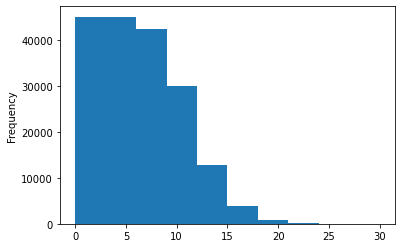

In [73]:
train_df.line_number.plot.hist()

In [74]:
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)

BY SETTING THE VALUE OF DEPTH TO 15 any "line number " value if it gets over 15 its values become tensors of all 0's where as any sample whose "line number" value is less than 15 gets turned into tensors of value 0's but with a 1 at the index equal to the "line_number" value

In [75]:
train_line_numbers_one_hot[:20]

<tf.Tensor: shape=(20, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [76]:
train_df["total_lines"].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

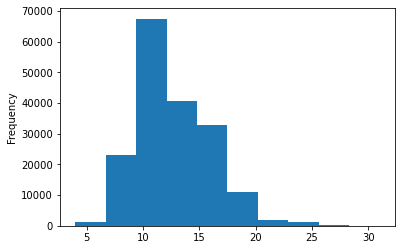

In [77]:
train_df.total_lines.plot.hist()

In [78]:
train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

In [79]:
train_total_lines_one_hot[:20]

<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
     

BUILDING THE TRIBRID EMBEDDING MODEL! 1.CREATE THE TOKEN INPUT,CHAR INPUT,LINE NUMBER INPUT AND THE TOTAL LINES INPUT
2.COMBINE CHAR AND TOKEN EMBEDDING INTO A SINGLE HYBRID EMBEDDING THEN COMBINE THE POSITIONAL EMBEDDING WITH THE HYBRID EMBEDDING TO FIND THE TRIBRID EMBEDDING 3.COMPILE THE MODEL 4.FIT THE MODEL 5.EVALUATE THE MODEL!

MAKE SURE THAT WHEREVER U CONCATENATE U PROVIDE A NAME TO THAT LAYER OTHERWISE IT IS GOING TO THROW AN ERROR!

In [107]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=((1,)), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=((15,)), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=((20,)), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [108]:
model_5.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
___________________________________________________________________________________________

WE ARE GOING TO APPLY LABEL SMOOTHING IN OUR LOSS FUNCTION WHICH IS A REGULARIZATION TECHNIQUE THAT INTRODUCES NOISE FOR THE LABELS WE SET THAT VALUE TO AROUND 0.2

In [109]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [110]:
for layer in model_5.layers:
    print(layers,layer.trainable)

<module 'keras.layers' from 'c:\\Anaconda\\envs\\tensorflow_env\\lib\\site-packages\\keras\\layers\\__init__.py'> True
<module 'keras.layers' from 'c:\\Anaconda\\envs\\tensorflow_env\\lib\\site-packages\\keras\\layers\\__init__.py'> True
<module 'keras.layers' from 'c:\\Anaconda\\envs\\tensorflow_env\\lib\\site-packages\\keras\\layers\\__init__.py'> True
<module 'keras.layers' from 'c:\\Anaconda\\envs\\tensorflow_env\\lib\\site-packages\\keras\\layers\\__init__.py'> False
<module 'keras.layers' from 'c:\\Anaconda\\envs\\tensorflow_env\\lib\\site-packages\\keras\\layers\\__init__.py'> True
<module 'keras.layers' from 'c:\\Anaconda\\envs\\tensorflow_env\\lib\\site-packages\\keras\\layers\\__init__.py'> True
<module 'keras.layers' from 'c:\\Anaconda\\envs\\tensorflow_env\\lib\\site-packages\\keras\\layers\\__init__.py'> True
<module 'keras.layers' from 'c:\\Anaconda\\envs\\tensorflow_env\\lib\\site-packages\\keras\\layers\\__init__.py'> True
<module 'keras.layers' from 'c:\\Anaconda\\envs

TO FIT THE DATA WE GOTTA CREATE THE TENSOR DATASETS

TRAIN DATASET

In [111]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_df_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_df_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [112]:
train_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [115]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 19s 34ms/step - loss: 0.9457 - accuracy: 0.8267 - val_loss: 0.9340 - val_accuracy: 0.8361
Epoch 2/5
562/562 [==============================] - 19s 34ms/step - loss: 0.9264 - accuracy: 0.8440 - val_loss: 0.9255 - val_accuracy: 0.8428
Epoch 3/5
562/562 [==============================] - 21s 37ms/step - loss: 0.9207 - accuracy: 0.8449 - val_loss: 0.9276 - val_accuracy: 0.8361
Epoch 4/5
562/562 [==============================] - 21s 37ms/step - loss: 0.9290 - accuracy: 0.8400 - val_loss: 0.9187 - val_accuracy: 0.8378
Epoch 5/5
562/562 [==============================] - 24s 42ms/step - loss: 0.9275 - accuracy: 0.8434 - val_loss: 0.9186 - val_accuracy: 0.8408


In [116]:
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.9149 - accuracy: 0.8467


[0.9149022102355957, 0.8466503620147705]

SAVING OUR MODEL!


In [122]:
model_5.save("tribrid_skimlit_model")

INFO:tensorflow:Assets written to: tribrid_skimlit_model\assets


INFO:tensorflow:Assets written to: tribrid_skimlit_model\assets


In [123]:
model_dir="tribrid_skimlit_model"
loaded_model=tf.keras.models.load_model("tribrid_skimlit_model")

NOW WE EVALUATE MODEL ON TEST DATASET!

In [132]:
test_pos_char_token_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,test_total_lines_one_hot,
                                                             test_sentences,test_chars))
test_pos_char_token_labels=tf.data.Dataset.from_tensor_slices(test_df_one_hot)
test_pos_char_token_dataset=tf.data.Dataset.zip((test_pos_char_token_data,test_pos_char_token_labels))

In [133]:
loaded_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, None)         0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
___________________________________________________________________________________________

In [140]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(val_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

945/945 [==============================] - 146s 155ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1], dtype=int64)>

In [141]:
%%time
test_pred_classes=[label_encoder.classes_[pred]for pred in test_preds]

CPU times: total: 7.61 s
Wall time: 6.57 s


In [143]:
val_df["prediction"]=test_pred_classes
val_df["pred_prob"]=tf.reduce_max(test_pred_probs,axis=1).numpy()
val_df["correct"]=val_df["prediction"]==val_df["target"]
val_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,10,BACKGROUND,0.594026,True
1,BACKGROUND,It is not clear whether these patients would b...,1,10,BACKGROUND,0.623225,True
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,10,BACKGROUND,0.351511,False
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,10,METHODS,0.819682,True
4,METHODS,Primary outcomes were improvement in quality o...,4,10,METHODS,0.869077,True
5,RESULTS,Sixty-five patients were randomized .,5,10,RESULTS,0.599150,True
6,RESULTS,Fifty-nine patients started treatment ( @ rece...,6,10,RESULTS,0.579494,True
7,RESULTS,Fifty-six patients took the full @ months of m...,7,10,RESULTS,0.544970,True
8,RESULTS,"Between the voriconazole and placebo groups , ...",8,10,RESULTS,0.827603,True
9,CONCLUSIONS,We were unable to show a beneficial effect of ...,9,10,CONCLUSIONS,0.666145,True


In [144]:
top_100_wrong=val_df[val_df["correct"]==False].sort_values("pred_prob",ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
10034,RESULTS,Secondary outcomes included time to TB treatme...,4,18,METHODS,0.945100,False
28193,RESULTS,Primary outcome measures were symptom self-rat...,5,14,METHODS,0.933174,False
15769,RESULTS,Dwellings in the ITN+IRS arm were sprayed with...,4,18,METHODS,0.930662,False
1027,RESULTS,Participants were randomized to tadalafil @ mg...,4,15,METHODS,0.930126,False
20408,RESULTS,"A double-blind , randomized , controlled trial...",2,18,METHODS,0.924134,False
...,...,...,...,...,...,...,...
412,RESULTS,"Therefore , LA administration may be useful fo...",13,15,CONCLUSIONS,0.855424,False
16599,RESULTS,All were examined by an ophthalmologist and ei...,4,14,METHODS,0.855420,False
18208,BACKGROUND,To compare pain response outcomes for patients...,0,11,OBJECTIVE,0.853944,False
10685,CONCLUSIONS,While both insertion methods proved equivalent...,5,8,RESULTS,0.853121,False


TOP WRONG PREDICTIONS ARE AS FOLLOWS!

In [145]:
for row in  top_100_wrong[0:10].itertuples():
    _,target,text,line_number,total_lines,prediction,pred_prob,_=row
    print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
    print(f"Text:\n{text}\n")
    print("-----\n")


Target: RESULTS, Pred: METHODS, Prob: 0.945099949836731, Line number: 4, Total lines: 18

Text:
Secondary outcomes included time to TB treatment and mortality .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.933173656463623, Line number: 5, Total lines: 14

Text:
Primary outcome measures were symptom self-rating scales ( Insomnia Severity Index -LSB- ISI -RSB- and the Montgomery sberg Depression Rating Scale -LSB- MADRS-S -RSB- ) , assessed before and after treatment with follow-up after @ and @ mo. .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9306617379188538, Line number: 4, Total lines: 18

Text:
Dwellings in the ITN+IRS arm were sprayed with two rounds of bendiocarb in @ .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9301260709762573, Line number: 4, Total lines: 15

Text:
Participants were randomized to tadalafil @ mg daily or placebo for @ months .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9241341948509216, Line number: 2, Total lines: 18

Text:
A double-blind , ra

WE CAN IMPLEMENT THIS MODEL TO THE PUBMED MODEL ON THE BACKEND OF PUBMED SITE! IT CAN SAVE THE RESEARCHES LOT OF TIME AND EFFORT TO READ THROUGH THE DATA/ABSTRACTS